In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 20,10
import numpy as np
import glob
from scipy import stats

In [2]:
cd CSVs

/Users/patrickbovard/Documents/GitHubRepos/mta-project-1/CSVs


#### Load Data

In [15]:
extension = 'txt'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
data = pd.concat([pd.read_csv(f) for f in all_filenames ])
data


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,00:00:00,REGULAR,7053483,2390505
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,04:00:00,REGULAR,7053511,2390508
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,08:00:00,REGULAR,7053534,2390536
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,12:00:00,REGULAR,7053618,2390596
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/11/2019,16:00:00,REGULAR,7053841,2390655
...,...,...,...,...,...,...,...,...,...,...,...
206852,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,05:00:00,REGULAR,5554,376
206853,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,09:00:00,REGULAR,5554,376
206854,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,13:00:00,REGULAR,5554,376
206855,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,05/03/2019,17:00:00,REGULAR,5554,376


### Clean Data

remove spaces from column names

In [16]:
data.columns = data.columns.str.replace(' ', '')

add Date_Time column 

In [17]:
data['Date_Time'] = pd.to_datetime(data['DATE'], cache=True) + pd.to_timedelta(data['TIME'])

Add Turnstile (Combining SCP,C/A, Station and Unit) and Weekday column

In [18]:
data['Turnstile'] = data['C/A'] + data['UNIT'] + data['SCP'] + data['STATION']
data['DATE'] = pd.to_datetime(data['DATE'], cache=True)
data['Week_Day'] = data['DATE'].dt.day_name()

In [19]:
grouped_day = data.groupby(['STATION','DATE'], as_index=False).agg({'ENTRIES': ['min', 'max'], 'EXITS': ['min', 'max']})
grouped_day.columns = [ 'Station','Date', 'ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']

In [20]:
grouped_day['Date'] = pd.to_datetime(grouped_day['Date'], cache=True)
grouped_day['Week_Day'] = grouped_day['Date'].dt.day_name()

In [21]:
grouped_day['Total_Entries'] = grouped_day['ENTRIES_MAX'] - grouped_day['ENTRIES_MIN']
grouped_day['Total_Exits'] = grouped_day['EXITS_MAX'] - grouped_day['EXITS_MIN']
grouped_day['Total_Traffic'] = grouped_day['Total_Exits'] + grouped_day['Total_Exits']
grouped_day.head()

,Station,Date,ENTRIES_MIN,ENTRIES_MAX,EXITS_MIN,EXITS_MAX,Week_Day,Total_Entries,Total_Exits,Total_Traffic
0,1 AV,2019-03-30,100798,955292159,12708,998669812,Saturday,955191361,998657104,1997314208
1,1 AV,2019-03-31,104309,955294001,13062,998670921,Sunday,955189692,998657859,1997315718
2,1 AV,2019-04-01,106948,955296212,13366,998672726,Monday,955189264,998659360,1997318720
3,1 AV,2019-04-02,110569,955297253,13856,998674559,Tuesday,955186684,998660703,1997321406
4,1 AV,2019-04-03,114965,955297587,14325,998676287,Wednesday,955182622,998661962,1997323924


In [22]:
grouped_day.drop(['ENTRIES_MIN','ENTRIES_MAX','EXITS_MIN','EXITS_MAX', 'Total_Entries', 'Total_Exits', ], axis=1)

grouped_day = grouped_day[(np.abs(stats.zscore(grouped_day['Total_Traffic'])) < 3)] #filtering

#### Find total traffic

Add shifted columns to show previous entries and exits

In [23]:
#All turnstiles have cumulative counts, previous data needs to be subtraced from current data 
#to find total entries/exits
grouped_time=data
grouped_time["PREV_TIME"] = data.groupby(["Turnstile"]).TIME.shift(1)
grouped_time["PREV_EXITS"] = data.groupby(["Turnstile"]).EXITS.shift(1)
grouped_time["PREV_ENTRIES"] = data.groupby(["Turnstile"]).ENTRIES.shift(1)
#grouped_time.head()

In [24]:
#drop first row of each turnstile b/c of shift down
grouped_time.dropna(subset=["PREV_ENTRIES"], axis=0, inplace=True) 

Remove counter errors from total entries/exits that occur from counters resetting

In [25]:
def get_daily_counts_exits(row, max_counter):
    counter_ex = row["EXITS"] - row["PREV_EXITS"]
    if counter_ex < 0:
        # Maybe counter is reversed?
        counter_ex = -counter_ex
    if counter_ex > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["EXITS"], row["PREV_EXITS"])
        counter = min(row["EXITS"], row["PREV_EXITS"])
    if counter_ex > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ex

def get_daily_counts_entries(row, max_counter):
    counter_ent = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter_ent < 0:
        # Maybe counter is reversed?
        counter_ent = -counter_ent
    if counter_ent > max_counter:
        # Maybe counter was reset to 0? 
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter_ent > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter_ent


# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!

In [26]:
grouped_time["TOTAL_ENTRIES"] = grouped_time.apply(get_daily_counts_entries, axis=1, max_counter=1000000)
grouped_time["TOTAL_EXITS"] = grouped_time.apply(get_daily_counts_exits, axis=1, max_counter=1000000)
#grouped_time["TOTAL_EXITS"] = grouped_time.apply(get_daily_counts, axis=1, max_counter=1000000)

In [27]:
grouped_time["TOTAL_TRAFFIC"] = grouped_time["TOTAL_EXITS"] + grouped_time["TOTAL_ENTRIES"]
grouped_time.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,Date_Time,Turnstile,Week_Day,PREV_TIME,PREV_EXITS,PREV_ENTRIES,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,04:00:00,REGULAR,7053511,2390508,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,00:00:00,2390505.0,7053483.0,28.0,3.0,31.0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,08:00:00,REGULAR,7053534,2390536,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,04:00:00,2390508.0,7053511.0,23.0,28.0,51.0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,12:00:00,REGULAR,7053618,2390596,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,08:00:00,2390536.0,7053534.0,84.0,60.0,144.0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,16:00:00,REGULAR,7053841,2390655,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,12:00:00,2390596.0,7053618.0,223.0,59.0,282.0
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,2019-05-11,20:00:00,REGULAR,7054133,2390702,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,16:00:00,2390655.0,7053841.0,292.0,47.0,339.0


remove total traffic outliers that are 3 sigmas from mean

In [28]:
grouped_time = grouped_time[(np.abs(stats.zscore(grouped_time['TOTAL_TRAFFIC'])) < 3)] #filtering

drop uneeded columns

In [29]:
grouped_time.drop(['C/A','UNIT','SCP','LINENAME', 'ENTRIES', 'EXITS', 'PREV_TIME', 'PREV_ENTRIES', 'PREV_EXITS'], axis=1)

,STATION,DIVISION,DATE,TIME,DESC,Date_Time,Turnstile,Week_Day,TOTAL_ENTRIES,TOTAL_EXITS,TOTAL_TRAFFIC
1,59 ST,BMT,2019-05-11,04:00:00,REGULAR,2019-05-11 04:00:00,A002R05102-00-0059 ST,Saturday,28.0,3.0,31.0
2,59 ST,BMT,2019-05-11,08:00:00,REGULAR,2019-05-11 08:00:00,A002R05102-00-0059 ST,Saturday,23.0,28.0,51.0
3,59 ST,BMT,2019-05-11,12:00:00,REGULAR,2019-05-11 12:00:00,A002R05102-00-0059 ST,Saturday,84.0,60.0,144.0
4,59 ST,BMT,2019-05-11,16:00:00,REGULAR,2019-05-11 16:00:00,A002R05102-00-0059 ST,Saturday,223.0,59.0,282.0
5,59 ST,BMT,2019-05-11,20:00:00,REGULAR,2019-05-11 20:00:00,A002R05102-00-0059 ST,Saturday,292.0,47.0,339.0
...,...,...,...,...,...,...,...,...,...,...,...
206852,RIT-ROOSEVELT,RIT,2019-05-03,05:00:00,REGULAR,2019-05-03 05:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,0.0,0.0,0.0
206853,RIT-ROOSEVELT,RIT,2019-05-03,09:00:00,REGULAR,2019-05-03 09:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,0.0,0.0,0.0
206854,RIT-ROOSEVELT,RIT,2019-05-03,13:00:00,REGULAR,2019-05-03 13:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,0.0,0.0,0.0
206855,RIT-ROOSEVELT,RIT,2019-05-03,17:00:00,REGULAR,2019-05-03 17:00:00,TRAM2R46900-05-01RIT-ROOSEVELT,Friday,0.0,0.0,0.0


In [30]:
#grouped_day = data.groupby(['DATE','Turnstile','STATION'], as_index=False).agg({'ENTRIES': ['min', 'max'], 'EXITS': ['min', 'max']})
#grouped = data.groupby(['STATION','DATE']).agg({'ENTRIES': ['min', 'max'], 'EXITS': ['min', 'max']})
#grouped = grouped.set_index('STATION')
#grouped.head()

In [31]:
#grouped_day.head()

In [32]:
#grouped.columns = [ 'Station', 'Date', 'ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
grouped_day.columns = [ 'Date', 'Turnstile', 'Station','ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped.columns = ['ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']
#grouped.dtypes

ValueError: Length mismatch: Expected axis has 10 elements, new values have 7 elements

Find total entries exits, and traffic

In [34]:
grouped_day['Total_Entries'] = grouped_day['ENTRIES_MAX'] - grouped_day['ENTRIES_MIN']
grouped_day['Total_Exits'] = grouped_day['EXITS_MAX'] - grouped_day['EXITS_MIN']
grouped_day['Total_Traffic'] = grouped_day['Total_Exits'] + grouped_day['Total_Entries']
#grouped_day.head()

NameError: name 'grouped_day' is not defined

In [ ]:
#grouped_day.drop(['ENTRIES_MIN','ENTRIES_MAX','EXITS_MIN','EXITS_MAX', 'Total_Entries', 'Total_Exits', ], axis=1)



Removing Outlier data from Total_traffic column (Removing anything outside 3 sigma)

In [35]:
grouped_day = grouped_day[(np.abs(stats.zscore(grouped_day['Total_Traffic'])) < 3)] #filtering

NameError: name 'grouped_day' is not defined

In [36]:
#grouped_time[grouped_time["ENTRIES"] < grouped_time["PREV_ENTRIES"]].head()

In [37]:
#grouped_time = data.sort_values(['Date_Time']).groupby(['Turnstile','STATION','DIVISION','Date_Time'],as_index = False).agg({'ENTRIES': ['diff'], 'EXITS': ['diff']})

In [38]:
#grouped_time = data
#grouped_time.sort_values(['Turnstile','Date_Time'],inplace = True)
#grouped_time.head(5)
#entry_vals = grouped_time['ENTRIES'].values
#exit_vals = grouped_time['EXITS'].values
#len(entry)
#len (entry_vals[:-1])
#len (entry_vals[1:])
#diffs_entry = entry_vals[1:] - entry_vals[:-1]
#diffs_exit = exit_vals[1:] - exit_vals[:-1]
#diffs_entry = np.append(diffs_entry,0)
#diffs_exit = np.append(diffs_exit,0)
#grouped_time['diffs_entry'] = grouped_time.groupby(['Turnstile'])['ENTRIES'].diff()
#grouped_time['diffs_exit'] = grouped_time.groupby(['Turnstile'])['EXITS'].diff()
#mask = !((grouped_time['diffs_entry'] == 0) && (grouped_time['diffs_exit'] == 0))
#mask =   grouped_time['diffs_entry'] == 0
#grouped_time = grouped_time[grouped_time['diffs_entry'] ]
#grouped_time['diffs_entry'] = grouped_time.rolling_apply(data['ENTRIES'], 2, lambda x: x[1] - x[0])
#grouped_time['diffs_exit'] = grouped_time.rolling_apply(data['EXITS'], 2, lambda x: x[1] - x[0])
#grouped_time.head()
#mask
#grouped_time.head()

In [39]:
#entry_vals = grouped_time['ENTRIES'].values
#entry_vals[1:]

In [40]:
#grouped_time = data.groupby(['STATION','TIME'], as_index=False).agg({'ENTRIES': ['diff'], 'EXITS': ['diff']})
#grouped_time.head()
#grouped_time.columns = ['Station', 'Time', 'ENTRIES_MIN', 'ENTRIES_MAX', 'EXITS_MIN', 'EXITS_MAX']


In [60]:
grouped_time['Total_Entries'] = grouped_time['ENTRIES_MAX'] - grouped_time['ENTRIES_MIN']
grouped_time['Total_Exits'] = grouped_time['EXITS_MAX'] - grouped_time['EXITS_MIN']
grouped_time['Total_Traffic'] = grouped_time['Total_Exits'] + grouped_time['Total_Entries']
grouped_time.head()

KeyError: 'ENTRIES_MAX'

In [42]:
grouped_time.drop(['ENTRIES_MIN','ENTRIES_MAX','EXITS_MIN','EXITS_MAX', 'Total_Entries', 'Total_Exits', ], axis=1)

KeyError: "['ENTRIES_MIN' 'ENTRIES_MAX' 'EXITS_MIN' 'EXITS_MAX' 'Total_Entries'\n 'Total_Exits'] not found in axis"

#### Combine data

### Finding top 10 visited stations

In [59]:
Total_ridership = grouped_day.groupby(['Station']).Total_Traffic.sum().reset_index()

NameError: name 'grouped_day' is not defined

In [ ]:
Total_ridership.sort_values(by=['Total_Traffic'],inplace = True, ascending = False)


In [ ]:
Row_list =[] 
indices = []
  
# Iterate over each row 
for index, rows in Total_ridership[:10].iterrows(): 
    # Create list for the current row 
#    my_list =[rows.STATION, rows.Total_Traffic] 
    my_list =rows.Total_Traffic 
    station_list = rows.Station
    # append the list to the final list 
    Row_list.append(my_list) 
    indices.append(station_list)
Total_ridership.head(10)


In [ ]:
plt.ylim(10000000,21000000)
plt.xlabel("Station")
plt.ylabel("Total Traffic")
plt.title("Total traffic for the period for top 10 busiest stations")
plt.bar(indices, Row_list)

Top 10 Busy Stations, We will focus on top5 of these.

In [ ]:
indices

### Find high traffic days

In [ ]:
Total_Weekly_ridership = grouped_day.groupby(['Week_Day']).Total_Traffic.sum().reset_index()
#Total_Weekly_ridership = grouped_day.groupby(['Week_Day']).Total_Traffic.mean().reset_index()
Total_Weekly_ridership.sort_values(by=['Total_Traffic'],inplace = True, ascending = False)
Total_Weekly_ridership.head()

In [ ]:
#plt.ylim(1610000000000,1620000000000)
plt.ylim(40000000,140000000)
plt.bar(Total_Weekly_ridership['Week_Day'], Total_Weekly_ridership['Total_Traffic'])

Based on this it seems like weekends see much less traffic compared to weekdays. So WWTF should focus more on weekdays 

In [ ]:
Top5 = Total_ridership['Station'][0:5].tolist()
Top5_stations = grouped_day[grouped_day['Station'].isin(Top5)]
Top5_station_weekly = Top5_stations.groupby(['Station','Week_Day']).Total_Traffic.sum().reset_index()
Top5_station_Daily = Top5_stations.groupby(['Station','Date']).Total_Traffic.sum().reset_index()
#Top5_station_weekly = Top5_stations.groupby(['Station','Week_Day']).Total_Traffic.mean().reset_index()

#### Weekly Plot for Top5 stations

In [ ]:

for stations in Top5:
    station = Top5_station_weekly[Top5_station_weekly['Station'] == stations]
#    print(station)
    plt.plot(station['Week_Day'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()



Looking at the plot seems like top5 stations are also showing a dip on weekends, but PATH NEW WTC station is oblitrating seeing the trend properly. This needs to be investigated further. Also, to see the trend for rest of the station we will do another plot removing the data for PATH NEW WTC

In [ ]:
for stations in Top5:
    if stations != "PATH NEW WTC" :
        station = Top5_station_weekly[Top5_station_weekly['Station'] == stations]
#    print(station)
        plt.plot(station['Week_Day'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This is also showing the dip in weekend more clearly. But GRD CNTRL-42 ST shows peak on thursday - which needs to be investigated.

In [ ]:
for stations in Top5:
    station = Top5_station_Daily[Top5_station_Daily['Station'] == stations]
#    print(station)
    plt.plot(station['Date'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This plot is also showing some abnormal values for some of the days for PATH NEW WTC. Two of these dates are looking on thursdays. We will look at rest of the stations removing PATH NEW WTC

In [ ]:
for stations in Top5:
    if stations != "PATH NEW WTC" :
        station = Top5_station_Daily[Top5_station_Daily['Station'] == stations]
#    print(station)
        plt.plot(station['Date'],station['Total_Traffic'],label = stations)
#plt.ylim(32500000000,40700000000)
#plt.ylim(400000000,405000000)
plt.legend()
plt.show()

This plot also seems to have some outliers. But In general trend is clear Traffic takes a dip on weekends and remains kind of static on weekdays

### Find peak hours

### Find high traffic areas for games

In [18]:
pwd

'/Users/patrickbovard/Documents/GitHubRepos/mta-project-1/CSVs'

### Reading in the 2019 MLB Schedule CSV data

In [14]:
schedule_2019 = pd.read_csv("2019SKED.TXT")

In [15]:
#scope out the data
schedule_2019.head()

,20190320,0,Wed,SEA,AL,1,OAK,AL.1,1.1,n,Unnamed: 10,Unnamed: 11
0,20190321,0,Thu,SEA,AL,2,OAK,AL,2,n,NaN,NaN
1,20190328,0,Thu,ANA,AL,1,OAK,AL,3,d,NaN,NaN
2,20190328,0,Thu,ARI,NL,1,LAN,NL,1,d,NaN,NaN
3,20190328,0,Thu,ATL,NL,1,PHI,NL,1,d,NaN,NaN
4,20190328,0,Thu,BAL,AL,1,NYA,AL,1,d,NaN,NaN


Columns are the first row, need to rename.

In [16]:
schedule_2019.columns=['Date','GameNumber','WeekDay','VisitingTeam','VisitingTeamLeague','VisitingTeamGame','HomeTeam','HomeTeamLeague','HomeTeamGame','GameTime','CancelIndicator','MakeUpDate']

In [17]:
#adding a DateTime element to the schedule data to match with the subway data
schedule_2019['DateTime'] = pd.to_datetime(schedule_2019.Date, format='%Y%m%d')

In [18]:
#Pulling the team abbreviations, each should have about 81 home games:
schedule_2019.groupby(['HomeTeam']).GameNumber.count()

HomeTeam
ANA    81
ARI    81
ATL    81
BAL    81
BOS    81
CHA    81
CHN    81
CIN    81
CLE    81
COL    81
DET    81
HOU    81
KCA    81
LAN    81
MIA    81
MIL    81
MIN    81
NYA    81
NYN    81
OAK    80
PHI    81
PIT    81
SDN    81
SEA    81
SFN    81
SLN    81
TBA    81
TEX    81
TOR    81
WAS    81
Name: GameNumber, dtype: int64

Finding New York Home games, with home teams NYA (Yankees) and NYN (Mets)

In [19]:
ny_home_games = ((schedule_2019.HomeTeam == 'NYA') |(schedule_2019.HomeTeam == 'NYN'))

In [20]:
ny_games_2019 = schedule_2019[ny_home_games]
ny_games_2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162 entries, 4 to 2414
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                162 non-null    int64         
 1   GameNumber          162 non-null    int64         
 2   WeekDay             162 non-null    object        
 3   VisitingTeam        162 non-null    object        
 4   VisitingTeamLeague  162 non-null    object        
 5   VisitingTeamGame    162 non-null    int64         
 6   HomeTeam            162 non-null    object        
 7   HomeTeamLeague      162 non-null    object        
 8   HomeTeamGame        162 non-null    int64         
 9   GameTime            162 non-null    object        
 10  CancelIndicator     6 non-null      object        
 11  MakeUpDate          6 non-null      object        
 12  DateTime            162 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(8)
memory 

Adding Date Time to ny_games dataframe:

In [21]:
ny_games_2019['DateTime'] = pd.to_datetime(ny_games_2019['Date'], format='%Y%m%d')

<ipython-input-21-05c8f9fc2885>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_games_2019['DateTime'] = pd.to_datetime(ny_games_2019['Date'], format='%Y%m%d')


In [22]:
ny_games_2019

,Date,GameNumber,WeekDay,VisitingTeam,VisitingTeamLeague,VisitingTeamGame,HomeTeam,HomeTeamLeague,HomeTeamGame,GameTime,CancelIndicator,MakeUpDate,DateTime
4,20190328,0,Thu,BAL,AL,1,NYA,AL,1,d,NaN,NaN,2019-03-28
27,20190330,0,Sat,BAL,AL,2,NYA,AL,2,d,NaN,NaN,2019-03-30
42,20190331,0,Sun,BAL,AL,3,NYA,AL,3,d,NaN,NaN,2019-03-31
61,20190401,0,Mon,DET,AL,5,NYA,AL,4,n,NaN,NaN,2019-04-01
72,20190402,0,Tue,DET,AL,6,NYA,AL,5,n,NaN,NaN,2019-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2366,20190925,0,Wed,MIA,NL,158,NYN,NL,158,n,NaN,NaN,2019-09-25
2379,20190926,0,Thu,MIA,NL,159,NYN,NL,159,n,NaN,NaN,2019-09-26
2384,20190927,0,Fri,ATL,NL,160,NYN,NL,160,n,NaN,NaN,2019-09-27
2399,20190928,0,Sat,ATL,NL,161,NYN,NL,161,n,NaN,NaN,2019-09-28


In [23]:
#Dropping columns that are not needed for merging the files
ny_games_2019.drop(columns = ['Date', 'GameNumber','VisitingTeam','VisitingTeamLeague','VisitingTeamGame', 'CancelIndicator','MakeUpDate'], inplace=True)

/Users/patrickbovard/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [24]:
ny_games_2019.head()

,WeekDay,HomeTeam,HomeTeamLeague,HomeTeamGame,GameTime,DateTime
4,Thu,NYA,AL,1,d,2019-03-28
27,Sat,NYA,AL,2,d,2019-03-30
42,Sun,NYA,AL,3,d,2019-03-31
61,Mon,NYA,AL,4,n,2019-04-01
72,Tue,NYA,AL,5,n,2019-04-02


Yankee Games only:

In [25]:
yankee_games = ny_games_2019[ny_games_2019.HomeTeam == 'NYA']
yankee_games.value_counts(yankee_games.HomeTeam)

HomeTeam
NYA    81
dtype: int64

Mets Games only:

In [26]:
mets_games = ny_games_2019[ny_games_2019.HomeTeam == 'NYN']
mets_games.value_counts(mets_games.HomeTeam)

HomeTeam
NYN    81
dtype: int64

Creating a dataframe of just the Mets/Yankee stops:

In [59]:
grouped_day.sample(3)

,Station,Date,ENTRIES_MIN,ENTRIES_MAX,EXITS_MIN,EXITS_MAX,Week_Day,Total_Entries,Total_Exits,Total_Traffic
9345,AQUEDUCT RACETR,2019-05-13,1,51046238,0,16917842,Monday,51046237,16917842,33835684
5890,5 AV/59 ST,2019-05-13,1,119333808,0,16440059,Monday,119333807,16440059,32880118
1604,157 ST,2019-06-03,774457,22261937,381292,9215774,Monday,21487480,8834482,17668964


In [29]:
stadium_stations = grouped_day[(grouped_day.Station == '161/YANKEE STAD') | (grouped_day.Station == 'METS-WILLETS PT')]
stadium_stations.head()

,Station,Date,ENTRIES_MIN,ENTRIES_MAX,EXITS_MIN,EXITS_MAX,Week_Day,Total_Entries,Total_Exits,Total_Traffic
1616,161/YANKEE STAD,2019-03-30,2,1399610147,0,1094593895,Saturday,1399610145,1094593895,2189187790
1617,161/YANKEE STAD,2019-03-31,2,1399608307,0,1094592883,Sunday,1399608305,1094592883,2189185766
1618,161/YANKEE STAD,2019-04-01,2,1399606792,0,1094592147,Monday,1399606790,1094592147,2189184294
1619,161/YANKEE STAD,2019-04-02,2,1399604731,0,1094590972,Tuesday,1399604729,1094590972,2189181944
1620,161/YANKEE STAD,2019-04-03,2,1399602603,0,1094589795,Wednesday,1399602601,1094589795,2189179590


Creating a DateTime object to help join to the subway data.

In [31]:
stadium_stations['DateTime'] = pd.to_datetime(stadium_stations['Date'], cache=True)

<ipython-input-31-4437dcc56464>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stadium_stations['DateTime'] = pd.to_datetime(stadium_stations['Date'], cache=True)


Adding Games to the stadium_stations dataframe:

In [32]:
stadium_with_yankeegames = stadium_stations.merge(yankee_games, how='left', on='DateTime')
stadium_with_yankeegames.head()

,Station,Date,ENTRIES_MIN,ENTRIES_MAX,EXITS_MIN,EXITS_MAX,Week_Day,Total_Entries,Total_Exits,Total_Traffic,DateTime,WeekDay,HomeTeam,HomeTeamLeague,HomeTeamGame,GameTime
0,161/YANKEE STAD,2019-03-30,2,1399610147,0,1094593895,Saturday,1399610145,1094593895,2189187790,2019-03-30,Sat,NYA,AL,2.0,d
1,161/YANKEE STAD,2019-03-31,2,1399608307,0,1094592883,Sunday,1399608305,1094592883,2189185766,2019-03-31,Sun,NYA,AL,3.0,d
2,161/YANKEE STAD,2019-04-01,2,1399606792,0,1094592147,Monday,1399606790,1094592147,2189184294,2019-04-01,Mon,NYA,AL,4.0,n
3,161/YANKEE STAD,2019-04-02,2,1399604731,0,1094590972,Tuesday,1399604729,1094590972,2189181944,2019-04-02,Tue,NYA,AL,5.0,n
4,161/YANKEE STAD,2019-04-03,2,1399602603,0,1094589795,Wednesday,1399602601,1094589795,2189179590,2019-04-03,Wed,NYA,AL,6.0,d


In [33]:
stadium_with_yankeegames.drop(columns=['WeekDay','HomeTeamLeague','HomeTeamGame','GameTime'], inplace=True)
stadium_with_yankeegames.head()

,Station,Date,ENTRIES_MIN,ENTRIES_MAX,EXITS_MIN,EXITS_MAX,Week_Day,Total_Entries,Total_Exits,Total_Traffic,DateTime,HomeTeam
0,161/YANKEE STAD,2019-03-30,2,1399610147,0,1094593895,Saturday,1399610145,1094593895,2189187790,2019-03-30,NYA
1,161/YANKEE STAD,2019-03-31,2,1399608307,0,1094592883,Sunday,1399608305,1094592883,2189185766,2019-03-31,NYA
2,161/YANKEE STAD,2019-04-01,2,1399606792,0,1094592147,Monday,1399606790,1094592147,2189184294,2019-04-01,NYA
3,161/YANKEE STAD,2019-04-02,2,1399604731,0,1094590972,Tuesday,1399604729,1094590972,2189181944,2019-04-02,NYA
4,161/YANKEE STAD,2019-04-03,2,1399602603,0,1094589795,Wednesday,1399602601,1094589795,2189179590,2019-04-03,NYA


In [34]:
stadium_with_yankeegames.rename(columns = {'HomeTeam':'YankeeGame'}, inplace=True)
stadium_with_yankeegames.head()

,Station,Date,ENTRIES_MIN,ENTRIES_MAX,EXITS_MIN,EXITS_MAX,Week_Day,Total_Entries,Total_Exits,Total_Traffic,DateTime,YankeeGame
0,161/YANKEE STAD,2019-03-30,2,1399610147,0,1094593895,Saturday,1399610145,1094593895,2189187790,2019-03-30,NYA
1,161/YANKEE STAD,2019-03-31,2,1399608307,0,1094592883,Sunday,1399608305,1094592883,2189185766,2019-03-31,NYA
2,161/YANKEE STAD,2019-04-01,2,1399606792,0,1094592147,Monday,1399606790,1094592147,2189184294,2019-04-01,NYA
3,161/YANKEE STAD,2019-04-02,2,1399604731,0,1094590972,Tuesday,1399604729,1094590972,2189181944,2019-04-02,NYA
4,161/YANKEE STAD,2019-04-03,2,1399602603,0,1094589795,Wednesday,1399602601,1094589795,2189179590,2019-04-03,NYA


Adding Mets Games and combining:

In [35]:
stadium_with_combined_games = stadium_with_yankeegames.merge(mets_games, how='left', on='DateTime')
stadium_with_combined_games.head()

,Station,Date,ENTRIES_MIN,ENTRIES_MAX,EXITS_MIN,EXITS_MAX,Week_Day,Total_Entries,Total_Exits,Total_Traffic,DateTime,YankeeGame,WeekDay,HomeTeam,HomeTeamLeague,HomeTeamGame,GameTime
0,161/YANKEE STAD,2019-03-30,2,1399610147,0,1094593895,Saturday,1399610145,1094593895,2189187790,2019-03-30,NYA,NaN,NaN,NaN,NaN,NaN
1,161/YANKEE STAD,2019-03-31,2,1399608307,0,1094592883,Sunday,1399608305,1094592883,2189185766,2019-03-31,NYA,NaN,NaN,NaN,NaN,NaN
2,161/YANKEE STAD,2019-04-01,2,1399606792,0,1094592147,Monday,1399606790,1094592147,2189184294,2019-04-01,NYA,NaN,NaN,NaN,NaN,NaN
3,161/YANKEE STAD,2019-04-02,2,1399604731,0,1094590972,Tuesday,1399604729,1094590972,2189181944,2019-04-02,NYA,NaN,NaN,NaN,NaN,NaN
4,161/YANKEE STAD,2019-04-03,2,1399602603,0,1094589795,Wednesday,1399602601,1094589795,2189179590,2019-04-03,NYA,NaN,NaN,NaN,NaN,NaN


In [36]:
stadium_with_combined_games.drop(columns=['WeekDay','HomeTeamLeague','HomeTeamGame','GameTime'], inplace=True)
stadium_with_combined_games.rename(columns = {'HomeTeam':'MetsGame'}, inplace=True)

In [37]:
stadium_with_combined_games.value_counts(stadium_with_combined_games.YankeeGame)

YankeeGame
NYA    72
dtype: int64

In [38]:
stadium_with_combined_games.value_counts(stadium_with_combined_games.MetsGame)

MetsGame
NYN    66
dtype: int64

Replacing na values with NoGame:

In [39]:
stadium_with_combined_games['YankeeGame'].fillna('NoGame', inplace=True)
stadium_with_combined_games['MetsGame'].fillna('NoGame', inplace=True)

In [40]:
#Combined Sheet with Mets/Yankee Games, pulling a sample to audit with mlb.com:
stadium_with_combined_games.sample(10)

,Station,Date,ENTRIES_MIN,ENTRIES_MAX,EXITS_MIN,EXITS_MAX,Week_Day,Total_Entries,Total_Exits,Total_Traffic,DateTime,YankeeGame,MetsGame
144,METS-WILLETS PT,2019-06-05,1,684543892,0,488703605,Wednesday,684543891,488703605,977407210,2019-06-05,NoGame,NYN
95,METS-WILLETS PT,2019-04-17,1,684527142,0,488702149,Wednesday,684527141,488702149,977404298,2019-04-17,NYA,NoGame
153,METS-WILLETS PT,2019-06-14,1,684547728,0,488703782,Friday,684547727,488703782,977407564,2019-06-14,NoGame,NYN
3,161/YANKEE STAD,2019-04-02,2,1399604731,0,1094590972,Tuesday,1399604729,1094590972,2189181944,2019-04-02,NYA,NoGame
122,METS-WILLETS PT,2019-05-14,1,684537624,0,488703231,Tuesday,684537623,488703231,977406462,2019-05-14,NYA,NoGame
119,METS-WILLETS PT,2019-05-11,1,684537181,0,488703215,Saturday,684537180,488703215,977406430,2019-05-11,NoGame,NYN
61,161/YANKEE STAD,2019-05-30,2,1399504682,0,1094532629,Thursday,1399504680,1094532629,2189065258,2019-05-30,NYA,NoGame
114,METS-WILLETS PT,2019-05-06,1,684536567,0,488703152,Monday,684536566,488703152,977406304,2019-05-06,NYA,NoGame
134,METS-WILLETS PT,2019-05-26,1,684542195,0,488703473,Sunday,684542194,488703473,977406946,2019-05-26,NoGame,NYN
21,161/YANKEE STAD,2019-04-20,2,1399571071,0,1094571453,Saturday,1399571069,1094571453,2189142906,2019-04-20,NYA,NoGame


All dates in sample set match with schedule correctly

Setting masks for games, no games to use for filtering:

In [41]:
yankee_game_mask = (stadium_with_combined_games.YankeeGame == 'NYA')
non_yankee_game_mask = (stadium_with_combined_games.YankeeGame == 'NoGame')
mets_game_mask = (stadium_with_combined_games.MetsGame == 'NYN')
non_mets_game_mask = (stadium_with_combined_games.MetsGame == 'NoGame')

Finding Yankees Game vs Non-Yankees Game at 161/Yankee Stadium Station:

In [44]:
#Yankee Stadium Stop w/ Yankee Games
yankee_game_df = stadium_with_combined_games[(stadium_with_combined_games.Station == '161/YANKEE STAD') & yankee_game_mask]

In [45]:
#Yankee Stadium Stop w/o Yankee Games:
non_yankee_game_df = stadium_with_combined_games[(stadium_with_combined_games.Station == '161/YANKEE STAD') & non_yankee_game_mask]

Finding Mets Game vs Non-Mets Game at METS-WILLETS PT Station:

In [46]:
#Mets Stadium Stop w/ Mets Games
mets_game_df = stadium_with_combined_games[(stadium_with_combined_games.Station == 'METS-WILLETS PT') & mets_game_mask]

In [47]:
#Mets Stadium Stop w/o Mets Games
non_mets_game_df = stadium_with_combined_games[(stadium_with_combined_games.Station == 'METS-WILLETS PT') & non_mets_game_mask]

In [49]:
#Avg. Entries on Yankee Game Days at Yankee Stadium Stop:
yankee_gd_traffic = yankee_game_df.Total_Traffic.mean()

In [50]:
#Avg. Entries on Non-Yankee Game Days at Yankee Stadium Stop:
yankee_ngd_traffic = non_yankee_game_df.Total_Traffic.mean()

In [51]:
#Avg. Entries on Mets Game Days at Mets Stadium Stop:
mets_gd_traffic = mets_game_df.Total_Traffic.mean()

In [52]:
#Avg. Entries on Non-Mets Game Days at Mets Stadium Stop:
mets_ngd_traffic = non_mets_game_df.Total_Traffic.mean()

Percent Difference: Yankee Games

In [53]:
((yankee_gd_traffic - yankee_ngd_traffic) / (yankee_ngd_traffic))*100

0.00045187968820297624

Percent Difference: Mets Games

In [54]:
((mets_gd_traffic - mets_ngd_traffic) / (mets_ngd_traffic))*100

2.2999973756703066e-05

Plotting GameDay Differences as a bar chart:

In [55]:
game_days = (yankee_gd_traffic, mets_gd_traffic)
non_game_days = (yankee_ngd_traffic, mets_ngd_traffic)

In [56]:
N = 2
ind = np.arange(N)
width = 0.3

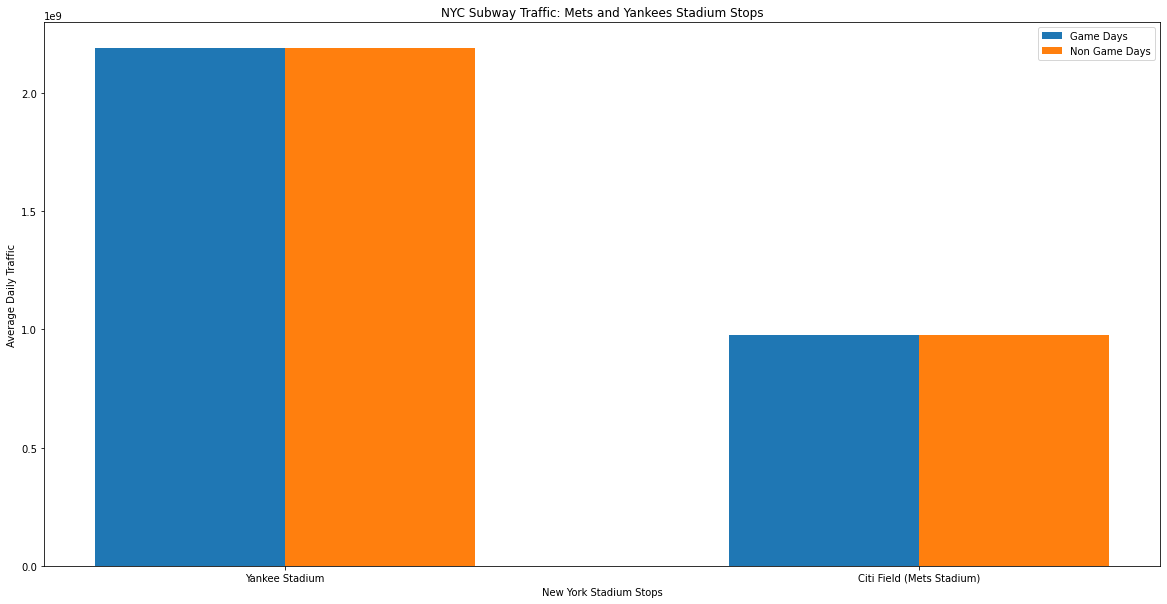

In [57]:
plt.bar(ind, game_days, width, label='Game Days')
plt.bar(ind + width, non_game_days, width, label='Non Game Days')
plt.xlabel('New York Stadium Stops')
plt.ylabel('Average Daily Traffic')
plt.title('NYC Subway Traffic: Mets and Yankees Stadium Stops')
plt.legend()
plt.xticks(ind + width / 2, ('Yankee Stadium', 'Citi Field (Mets Stadium)'));

### Find top stations in each area code

In [ ]:
loc_data = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
print(loc_data.Borough.unique())
loc_data.tail()